<h1> Computer Science Final Project: Invasive Ductal Carcinoma </h1>

<h2> Introduction </h2>

For my CM3070 final project, I will be exploring deep learning solutions for diagnosis of Invasive Ductal Carcinoma from histopathological samples of tissue. 

The structure of this notebook will be:
1. Setup (loading dependencies, datasets)
2. Preprocessing Data
3. Make Baseline model
4. Make Other models 
5. Evaluate results (done in report)
6. Conclusion (done in report)

The data is taken from Kaggle dataset "Breast Histopathological Images" at this link: https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images

Background Info:
The original dataset consisted of 162 whole mount slide images of Breast Cancer (BCa) specimens scanned at 40x. From that, 277,524 patches of size 50 x 50 were extracted (198,738 IDC negative and 78,786 IDC positive). The raw file is separated by patient id & by IDC positive and IDC negative portions from their specific specimen.|

In [1]:
#Check for GPU 
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


<h2> Project Setup </h2>

In [2]:
#import possible dependencies
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import itertools
import os, stat, time
from os.path import dirname as up
import shutil
import glob
from PIL import Image


import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet101
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping 




In [3]:
#load pictures
from glob import glob
import random

BASE_DIR = 'IDC_regular_ps50_idx5'  
N_IMAGES_PER_CATEGORY = 25 #change to what I need

def get_sample_images(directory, n_images):
    images = os.listdir(directory)
    sampled_images = random.sample(images, min(n_images, len(images)))  
    return [os.path.join(directory, img) for img in sampled_images]

all_samples = []

patient_folders = [os.path.join(BASE_DIR, patient) for patient in os.listdir(BASE_DIR)]

for patient in patient_folders:
    positive_dir = os.path.join(patient, '1')
    negative_dir = os.path.join(patient, '0')
    
    positive_samples = get_sample_images(positive_dir, N_IMAGES_PER_CATEGORY // 2)
    negative_samples = get_sample_images(negative_dir, N_IMAGES_PER_CATEGORY // 2)
    
    all_samples.extend(positive_samples)
    all_samples.extend(negative_samples)

random.shuffle(all_samples)

print(all_samples[:3])

['IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x551_y301_class1.png', 'IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x801_y351_class1.png', 'IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x851_y251_class1.png']


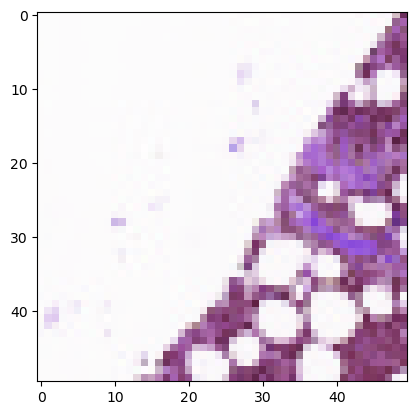

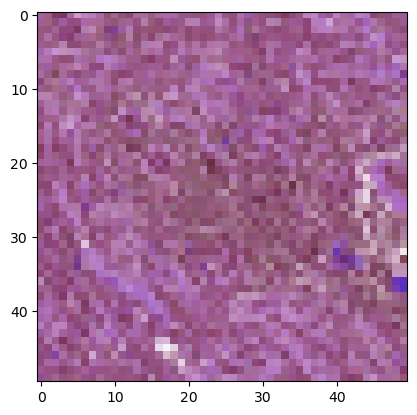

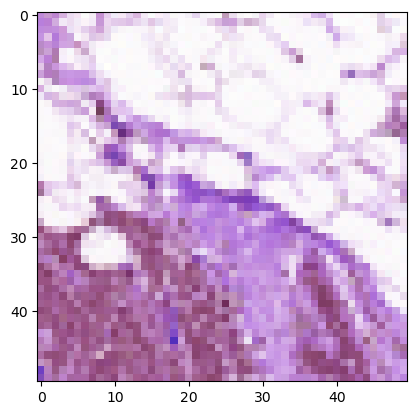

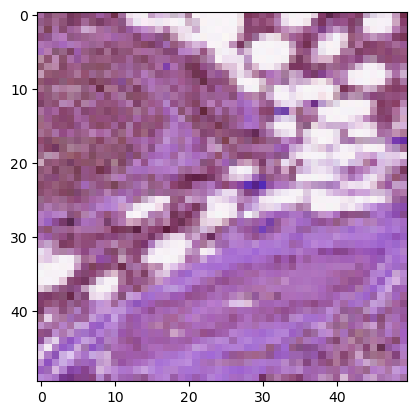

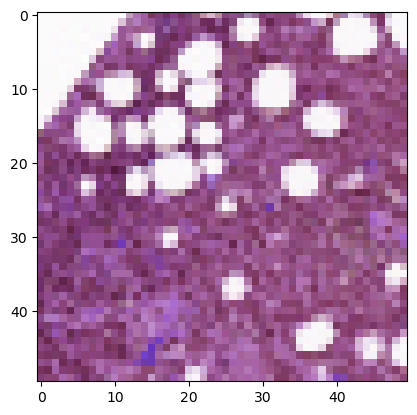

In [4]:
#display sample images
import cv2
import matplotlib.pyplot as plt
for i in all_samples[:5]:
    img=cv2.imread(i)
    img_1=cv2.resize(img,(50,50))
    plt.imshow(img_1,cmap='binary')
    plt.show()

In [5]:
#save images and labels to array #

images=[]
labels=[]

# selected_files = random.sample(all_samples, 15000)

#for loop to save images and labels to array & gaussian
for i in all_samples:
    if i.endswith('.png'):
        label=i[-5]
        img=cv2.imread(i)
        img_1=cv2.resize(img,(100,100))
        img_2 = cv2.GaussianBlur(img_1,(5,5),cv2.BORDER_DEFAULT)
        images.append(img_2)
        labels.append(label)

In [6]:
# Make X-axis
X=np.stack(images)

In [7]:
# make y-axis
from tensorflow.keras.utils import to_categorical
labels = [int(label) for label in labels]
y = np.array(labels)

In [8]:
#normalize the data
X=X/255

In [9]:
#make train test split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=69,test_size=0.2)

In [10]:
sample_image_shape = X_train[0].shape
print(sample_image_shape)

(100, 100, 3)


<h2>Making Baseline Model </h2>

In [11]:
# Make Baseline Model #
eval_metrics = [tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall'),
                 tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                 tf.keras.metrics.AUC(name='auc')]

def baseline_model(input_shape=sample_image_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=eval_metrics)
    return model

In [12]:
#  Model A # 

# Initialising the model with the parameters
model_a = VGG16(weights='imagenet', include_top=False, input_shape=sample_image_shape, pooling = 'max')

# Freezing the layers within the model
for layer in model_a.layers:
    layer.trainable = False

def get_model_a(input_shape=sample_image_shape):
    model = tf.keras.Sequential([
        model_a,
        tf.keras.layers.BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
        tf.keras.layers. Dense(256, kernel_regularizer= tf.keras.regularizers.l2(l= 0.016), activity_regularizer= tf.keras.regularizers.l1(0.006), bias_regularizer= tf.keras.regularizers.l1(0.006), activation= 'relu'),
        tf.keras.layers.Dropout(rate= 0.45, seed= 123),
        tf.keras.layers.Dense(1, activation= 'sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=eval_metrics)
    return model




In [13]:
# Model B#

# Initialising the model with the parameters
model_b = ResNet101(weights='imagenet', include_top=False, input_shape=sample_image_shape, pooling = 'max')

# Freezing the layers within the model
for layer in model_b.layers:
    layer.trainable = False

def get_model_b(input_shape=sample_image_shape):
    model = tf.keras.Sequential([
        model_b,
        tf.keras.layers.BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
        tf.keras.layers.Dense(256, kernel_regularizer= tf.keras.regularizers.l2(l= 0.016), activity_regularizer= tf.keras.regularizers.l1(0.006), bias_regularizer= tf.keras.regularizers.l1(0.006), activation= 'relu'),
        tf.keras.layers.Dropout(rate= 0.45, seed= 123),
        tf.keras.layers.Dense(1, activation= 'sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=eval_metrics)
    return model

In [14]:
# Training function
early_stop=EarlyStopping(monitor='val_accuracy',patience=25)
def train_model(model, train_data, train_labels, validation_data, validation_labels, epochs=100, callback=early_stop):
    history = model.fit(train_data, train_labels, epochs=epochs, batch_size = 50, validation_data=(validation_data, validation_labels), callbacks=[callback])
    return history

In [15]:
# Plotting history function
def plot_training_history(history, title='Training History'):
    fig, axs = plt.subplots(3, 2, figsize=(15, 10))
    
    # Plot training & validation accuracy values
    axs[0, 0].plot(history.history['accuracy'])
    axs[0, 0].plot(history.history['val_accuracy'])
    axs[0, 0].set_title('Model accuracy')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].legend(['Train', 'Test'], loc='upper left')
    
    # Plot training & validation loss values
    axs[0, 1].plot(history.history['loss'])
    axs[0, 1].plot(history.history['val_loss'])
    axs[0, 1].set_title('Model loss')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].legend(['Train', 'Test'], loc='upper left')
    
    # Plot training & validation precision values
    axs[1, 0].plot(history.history['precision'])
    axs[1, 0].plot(history.history['val_precision'])
    axs[1, 0].set_title('Model precision')
    axs[1, 0].set_ylabel('Precision')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].legend(['Train', 'Test'], loc='upper left')
    
    # Plot training & validation recall values
    axs[1, 1].plot(history.history['recall'])
    axs[1, 1].plot(history.history['val_recall'])
    axs[1, 1].set_title('Model recall')
    axs[1, 1].set_ylabel('Recall')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].legend(['Train', 'Test'], loc='upper left')
    
    # Plot training & validation AUC values
    axs[2, 0].plot(history.history['auc'])
    axs[2, 0].plot(history.history['val_auc'])
    axs[2, 0].set_title('Model auc')
    axs[2, 0].set_ylabel('Auc')
    axs[2, 0].set_xlabel('Epoch')
    axs[2, 0].legend(['Train', 'Test'], loc='upper left')
    
    
    
    plt.tight_layout()
    plt.show()

In [16]:
# Training Baseline Model
baseline_model = baseline_model()
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 33856)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               4333696   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

Epoch 1/100
108/108 [==============================] - 6s 19ms/step - loss: 0.6832 - precision: 0.7601 - recall: 0.3193 - accuracy: 0.6120 - auc: 0.7261 - val_loss: 0.5662 - val_precision: 0.7860 - val_recall: 0.6361 - val_accuracy: 0.7244 - val_auc: 0.8080
Epoch 2/100
108/108 [==============================] - 2s 15ms/step - loss: 0.5736 - precision: 0.7261 - recall: 0.6739 - accuracy: 0.7119 - auc: 0.7746 - val_loss: 0.5292 - val_precision: 0.8718 - val_recall: 0.5444 - val_accuracy: 0.7252 - val_auc: 0.8483
Epoch 3/100
108/108 [==============================] - 2s 15ms/step - loss: 0.5187 - precision: 0.7961 - recall: 0.6826 - accuracy: 0.7556 - auc: 0.8201 - val_loss: 0.4744 - val_precision: 0.8566 - val_recall: 0.6870 - val_accuracy: 0.7804 - val_auc: 0.8671
Epoch 4/100
108/108 [==============================] - 2s 15ms/step - loss: 0.5041 - precision: 0.7901 - recall: 0.7134 - accuracy: 0.7636 - auc: 0.8333 - val_loss: 0.4666 - val_precision: 0.7969 - val_recall: 0.8166 - val_acc

Epoch 33/100
108/108 [==============================] - 2s 15ms/step - loss: 0.2807 - precision: 0.8935 - recall: 0.8706 - accuracy: 0.8842 - auc: 0.9523 - val_loss: 0.6114 - val_precision: 0.7947 - val_recall: 0.7380 - val_accuracy: 0.7677 - val_auc: 0.8285
Epoch 34/100
108/108 [==============================] - 2s 15ms/step - loss: 0.2531 - precision: 0.9013 - recall: 0.8860 - accuracy: 0.8952 - auc: 0.9611 - val_loss: 0.6357 - val_precision: 0.7699 - val_recall: 0.7744 - val_accuracy: 0.7655 - val_auc: 0.8282
Epoch 35/100
108/108 [==============================] - 2s 15ms/step - loss: 0.2379 - precision: 0.9088 - recall: 0.9030 - accuracy: 0.9068 - auc: 0.9660 - val_loss: 0.6766 - val_precision: 0.7933 - val_recall: 0.7205 - val_accuracy: 0.7603 - val_auc: 0.8247
Epoch 36/100
108/108 [==============================] - 2s 15ms/step - loss: 0.2343 - precision: 0.9083 - recall: 0.8906 - accuracy: 0.9010 - auc: 0.9670 - val_loss: 0.6586 - val_precision: 0.7741 - val_recall: 0.7234 - val

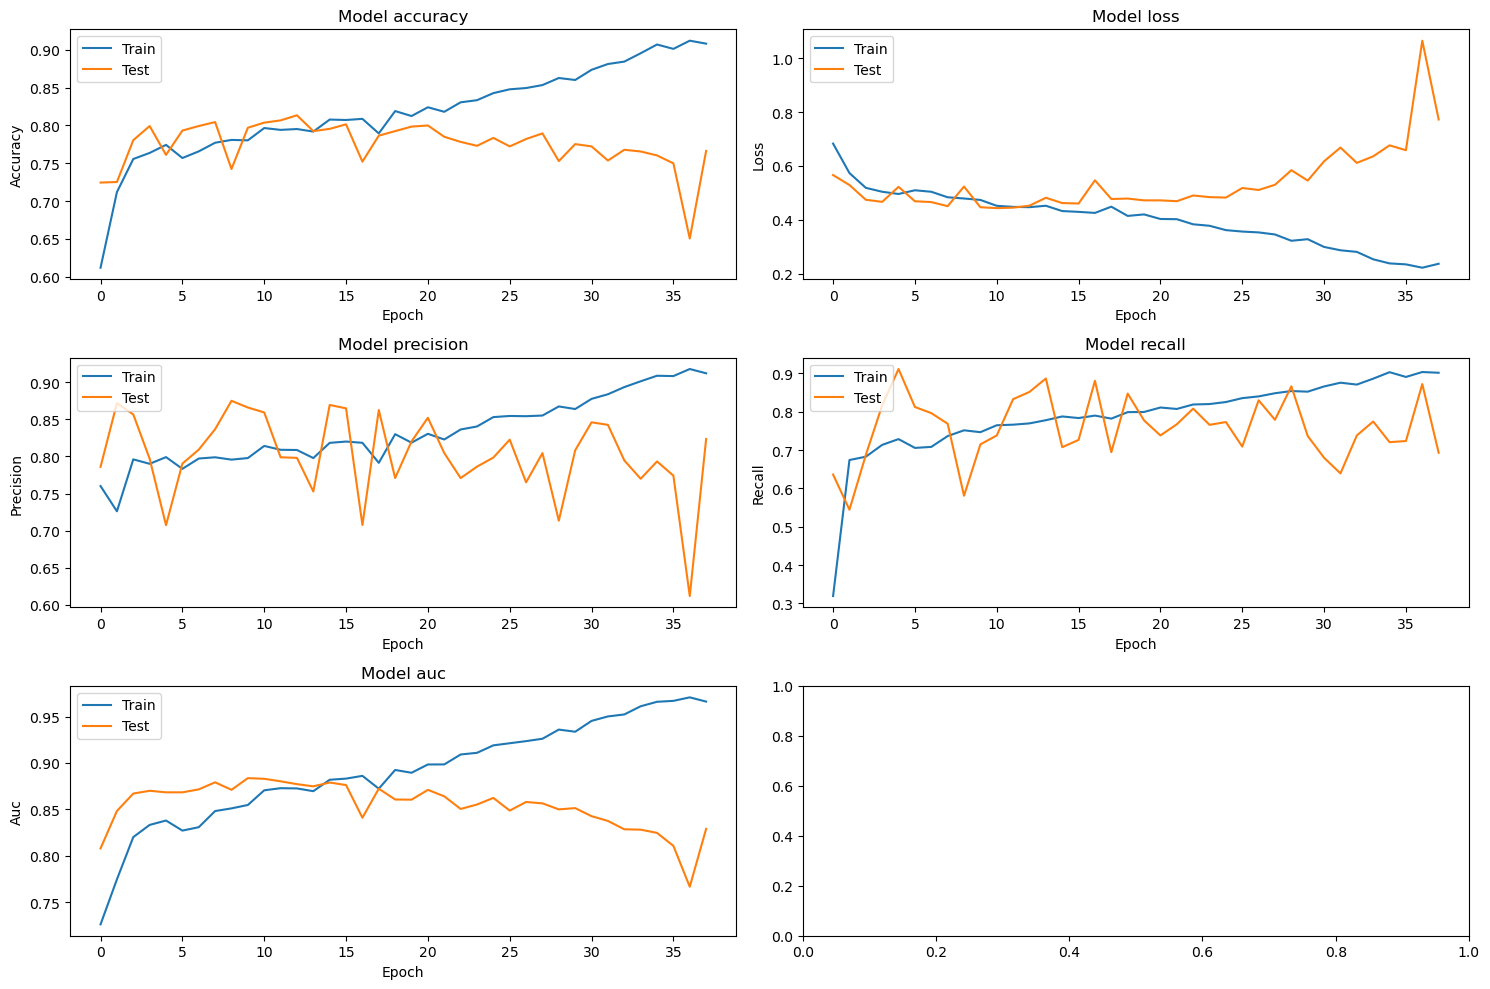

In [17]:
history_baseline = train_model(baseline_model, X_train, y_train, X_test, y_test)
plot_training_history(history_baseline, "Baseline Model")

In [18]:
# Training Model A
modelA = get_model_a()
modelA.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 14,848,321
Trainable params: 132,609
Non-trainable params: 14,715,712
_________________________________________________________________


Epoch 1/100
108/108 [==============================] - 8s 58ms/step - loss: 3.3878 - precision: 0.7707 - recall: 0.7212 - accuracy: 0.7534 - auc: 0.8076 - val_loss: 1.5940 - val_precision: 0.7779 - val_recall: 0.8108 - val_accuracy: 0.7842 - val_auc: 0.8583
Epoch 2/100
108/108 [==============================] - 5s 46ms/step - loss: 1.1307 - precision: 0.8099 - recall: 0.7529 - accuracy: 0.7895 - auc: 0.8610 - val_loss: 0.8708 - val_precision: 0.7901 - val_recall: 0.7889 - val_accuracy: 0.7842 - val_auc: 0.8665
Epoch 3/100
108/108 [==============================] - 5s 44ms/step - loss: 0.7302 - precision: 0.8101 - recall: 0.7668 - accuracy: 0.7950 - auc: 0.8645 - val_loss: 0.6639 - val_precision: 0.8112 - val_recall: 0.7569 - val_accuracy: 0.7849 - val_auc: 0.8658
Epoch 4/100
108/108 [==============================] - 5s 44ms/step - loss: 0.6369 - precision: 0.8090 - recall: 0.7567 - accuracy: 0.7905 - auc: 0.8691 - val_loss: 0.6165 - val_precision: 0.8240 - val_recall: 0.7293 - val_acc

Epoch 33/100
108/108 [==============================] - 5s 44ms/step - loss: 0.5359 - precision: 0.8203 - recall: 0.7947 - accuracy: 0.8116 - auc: 0.8913 - val_loss: 0.5652 - val_precision: 0.8053 - val_recall: 0.7889 - val_accuracy: 0.7939 - val_auc: 0.8759
Epoch 34/100
108/108 [==============================] - 5s 44ms/step - loss: 0.5504 - precision: 0.8148 - recall: 0.8007 - accuracy: 0.8106 - auc: 0.8863 - val_loss: 0.5632 - val_precision: 0.8073 - val_recall: 0.7744 - val_accuracy: 0.7894 - val_auc: 0.8750
Epoch 35/100
108/108 [==============================] - 5s 45ms/step - loss: 0.5308 - precision: 0.8126 - recall: 0.8026 - accuracy: 0.8101 - auc: 0.8940 - val_loss: 0.5830 - val_precision: 0.8239 - val_recall: 0.7424 - val_accuracy: 0.7864 - val_auc: 0.8663


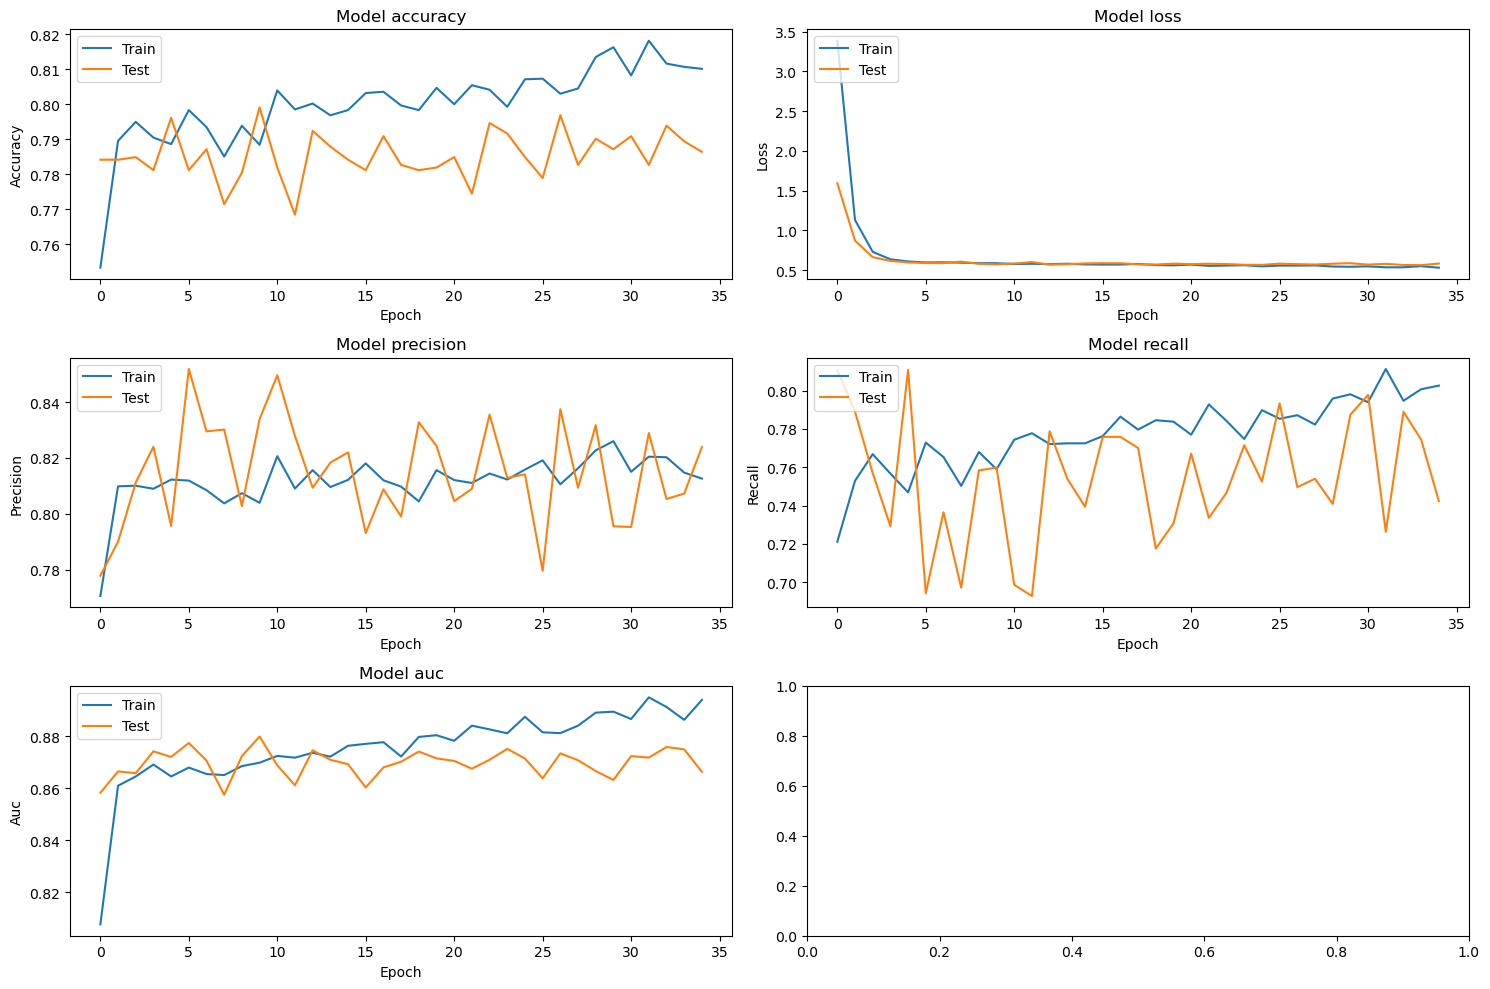

In [19]:
history_modelA = train_model(modelA, X_train, y_train, X_test, y_test)
plot_training_history(history_modelA, "VGG16 Model")

In [20]:
# Training Model B
modelB = get_model_b()
modelB.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Functional)       (None, 2048)              42658176  
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_4 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 43,191,169
Trainable params: 528,897
Non-trainable params: 42,662,272
_________________________________________________________________


Epoch 1/100
108/108 [==============================] - 13s 85ms/step - loss: 2.8669 - precision: 0.7341 - recall: 0.7014 - accuracy: 0.7238 - auc: 0.7845 - val_loss: 1.8085 - val_precision: 0.5131 - val_recall: 1.0000 - val_accuracy: 0.5131 - val_auc: 0.7384
Epoch 2/100
108/108 [==============================] - 7s 68ms/step - loss: 1.0369 - precision: 0.7525 - recall: 0.7202 - accuracy: 0.7434 - auc: 0.8069 - val_loss: 0.9040 - val_precision: 0.7770 - val_recall: 0.6900 - val_accuracy: 0.7394 - val_auc: 0.8085
Epoch 3/100
108/108 [==============================] - 7s 68ms/step - loss: 0.7877 - precision: 0.7580 - recall: 0.7138 - accuracy: 0.7447 - auc: 0.8070 - val_loss: 0.7481 - val_precision: 0.7515 - val_recall: 0.7351 - val_accuracy: 0.7394 - val_auc: 0.8117
Epoch 4/100
108/108 [==============================] - 7s 68ms/step - loss: 0.7288 - precision: 0.7474 - recall: 0.7123 - accuracy: 0.7376 - auc: 0.8033 - val_loss: 0.6853 - val_precision: 0.8039 - val_recall: 0.6565 - val_ac

Epoch 33/100
108/108 [==============================] - 7s 68ms/step - loss: 0.6186 - precision: 0.7479 - recall: 0.7285 - accuracy: 0.7432 - auc: 0.8172 - val_loss: 0.6035 - val_precision: 0.7902 - val_recall: 0.6579 - val_accuracy: 0.7349 - val_auc: 0.8230
Epoch 34/100
108/108 [==============================] - 7s 68ms/step - loss: 0.6099 - precision: 0.7669 - recall: 0.7138 - accuracy: 0.7501 - auc: 0.8170 - val_loss: 0.5860 - val_precision: 0.7933 - val_recall: 0.6929 - val_accuracy: 0.7498 - val_auc: 0.8309
Epoch 35/100
108/108 [==============================] - 7s 68ms/step - loss: 0.6070 - precision: 0.7526 - recall: 0.7221 - accuracy: 0.7442 - auc: 0.8187 - val_loss: 0.5843 - val_precision: 0.7716 - val_recall: 0.7278 - val_accuracy: 0.7498 - val_auc: 0.8329
Epoch 36/100
108/108 [==============================] - 7s 68ms/step - loss: 0.6125 - precision: 0.7617 - recall: 0.7236 - accuracy: 0.7503 - auc: 0.8181 - val_loss: 0.5959 - val_precision: 0.7903 - val_recall: 0.6914 - val

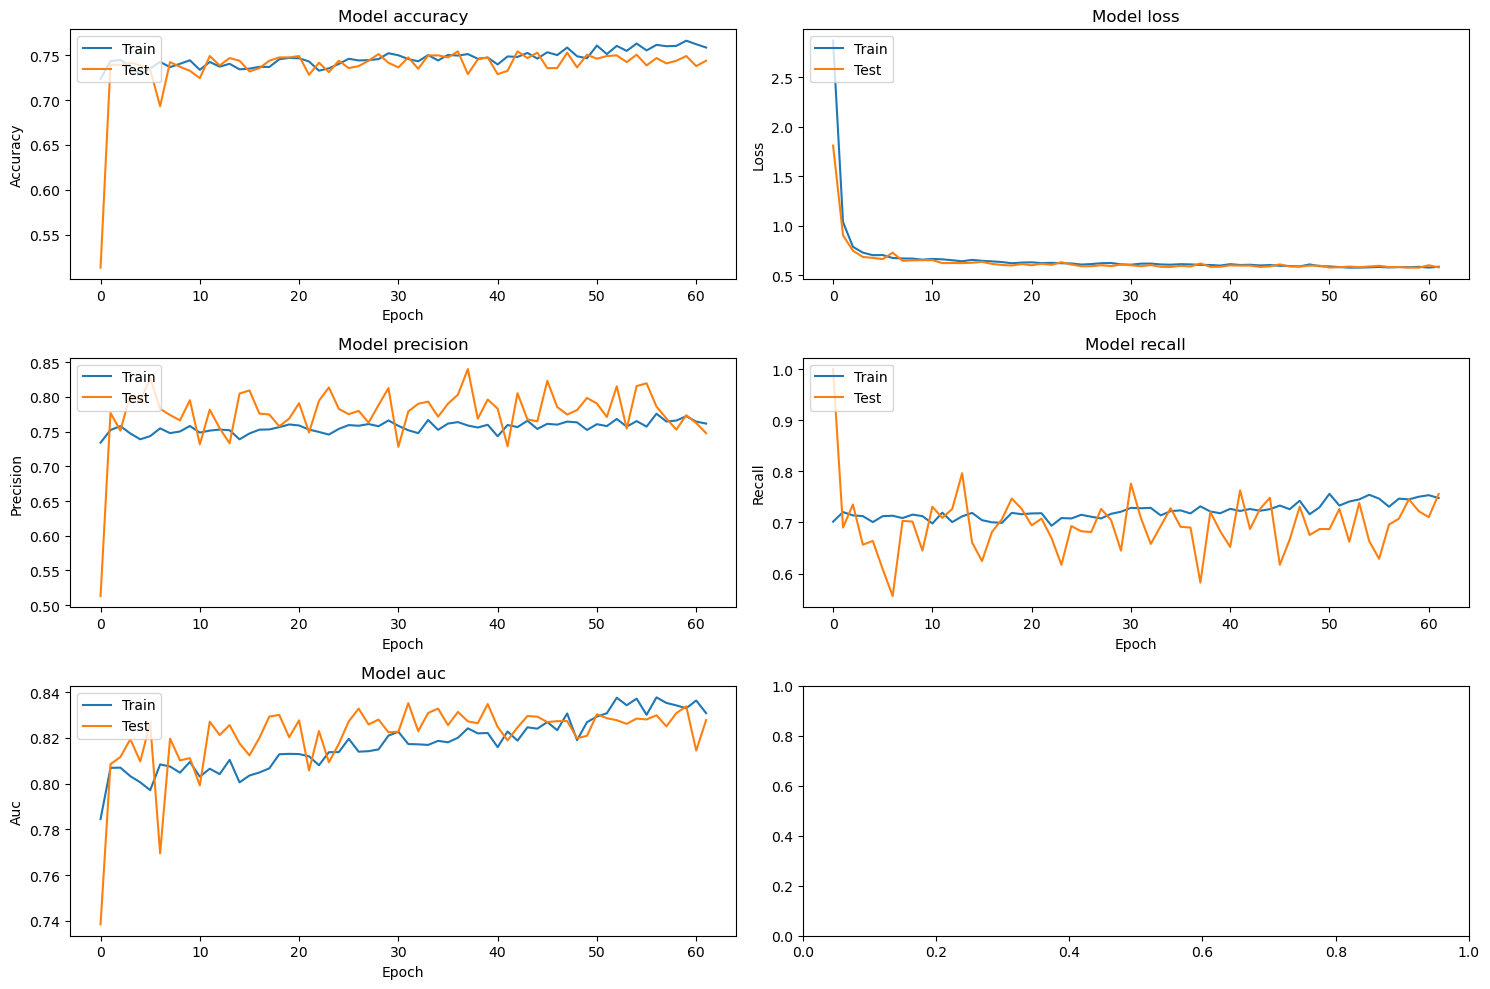

In [21]:
history_modelB= train_model(modelB, X_train, y_train, X_test, y_test)
plot_training_history(history_modelB, "ResNet101 Model")

In [22]:
# Combined Model 
from tensorflow.keras.layers import Concatenate, Flatten, Input

input_tensor = Input(shape=sample_image_shape)

vgg16_base = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor, pooling= 'max')
resnet101_base = ResNet101(include_top= False, weights= "imagenet", input_tensor= input_tensor, pooling= 'max')

vgg16_output = Flatten()(vgg16_base.output)
resnet101_output = Flatten()(resnet101_base.output)

modelA_B_output = Concatenate()([vgg16_output, resnet101_output])


# Add dense layers and dropout for regularization
x = tf.keras.layers.Flatten()(modelA_B_output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

#Final Layer
output_layer = layers.Dense(1, activation='sigmoid')(x)

#Model Definition 
merged_model = tf.keras.Model(inputs=input_tensor,outputs=output_layer)

merged_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=eval_metrics)
merged_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 50, 50, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

Epoch 1/100
108/108 [==============================] - 47s 339ms/step - loss: 0.9812 - precision: 0.7673 - recall: 0.7331 - accuracy: 0.7555 - auc: 0.8145 - val_loss: 14.6912 - val_precision: 0.5131 - val_recall: 1.0000 - val_accuracy: 0.5131 - val_auc: 0.5000
Epoch 2/100
108/108 [==============================] - 35s 322ms/step - loss: 0.4771 - precision: 0.7981 - recall: 0.7687 - accuracy: 0.7886 - auc: 0.8539 - val_loss: 0.8056 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.4869 - val_auc: 0.7456
Epoch 3/100
108/108 [==============================] - 34s 314ms/step - loss: 0.5041 - precision: 0.7750 - recall: 0.7382 - accuracy: 0.7636 - auc: 0.8360 - val_loss: 0.7877 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.4869 - val_auc: 0.7511
Epoch 4/100
108/108 [==============================] - 34s 316ms/step - loss: 0.4664 - precision: 0.8002 - recall: 0.7653 - accuracy: 0.7886 - auc: 0.8608 - val_loss: 0.7336 - val_precision: 0.0000e+00 -

108/108 [==============================] - 34s 316ms/step - loss: 0.4146 - precision: 0.8106 - recall: 0.8033 - accuracy: 0.8092 - auc: 0.8917 - val_loss: 0.7400 - val_precision: 0.6522 - val_recall: 0.0873 - val_accuracy: 0.5078 - val_auc: 0.7700
Epoch 33/100
108/108 [==============================] - 34s 314ms/step - loss: 0.4283 - precision: 0.8073 - recall: 0.8018 - accuracy: 0.8065 - auc: 0.8845 - val_loss: 0.6214 - val_precision: 0.9045 - val_recall: 0.4687 - val_accuracy: 0.7020 - val_auc: 0.6915
Epoch 34/100
108/108 [==============================] - 34s 316ms/step - loss: 0.4056 - precision: 0.8166 - recall: 0.8187 - accuracy: 0.8187 - auc: 0.8973 - val_loss: 0.6682 - val_precision: 0.8883 - val_recall: 0.5328 - val_accuracy: 0.7259 - val_auc: 0.8527
Epoch 35/100
108/108 [==============================] - 34s 319ms/step - loss: 0.3898 - precision: 0.8172 - recall: 0.8304 - accuracy: 0.8235 - auc: 0.9052 - val_loss: 0.5627 - val_precision: 0.9016 - val_recall: 0.5735 - val_accu

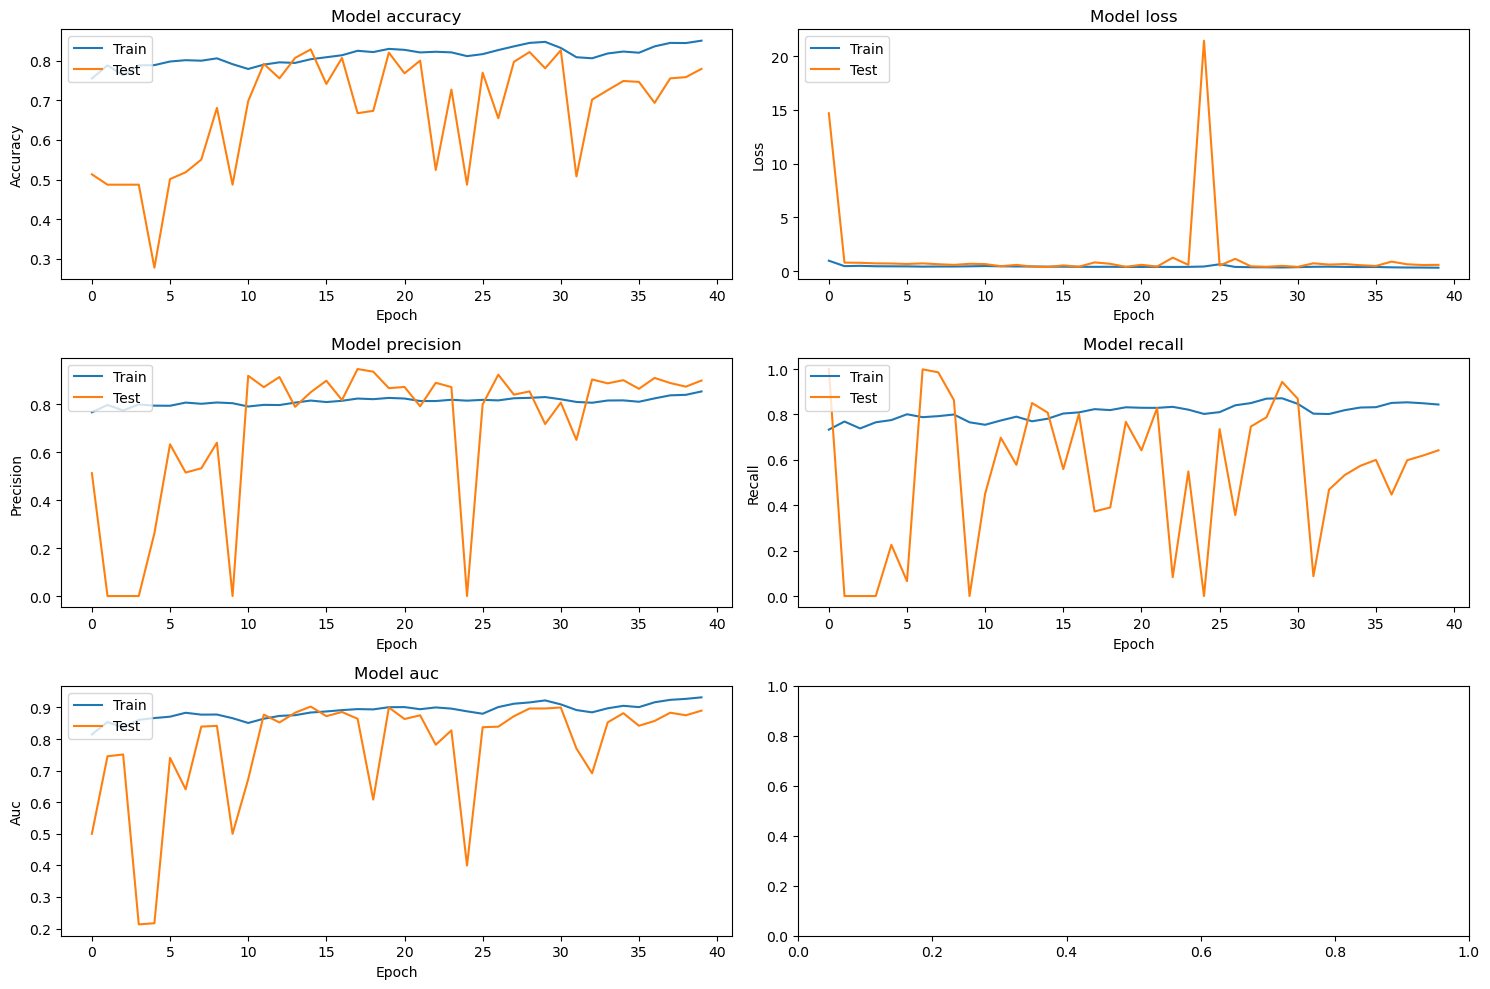

In [23]:
# Training Merged Model
history_merged = train_model(merged_model, X_train, y_train, X_test, y_test)
plot_training_history(history_merged, "Merged Model")

In [35]:
# Plot Confusion Matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(true_labels, predictions, title="Confusion Matrix"):
    cm = confusion_matrix(true_labels, np.round(predictions))
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

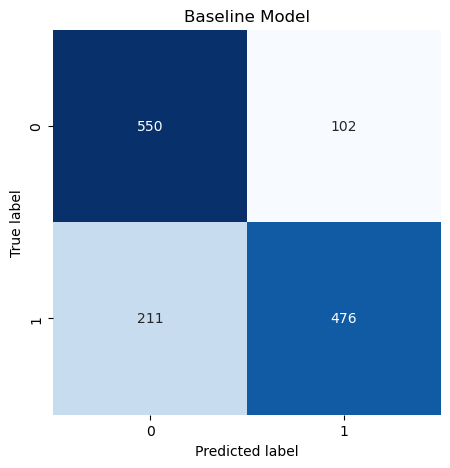

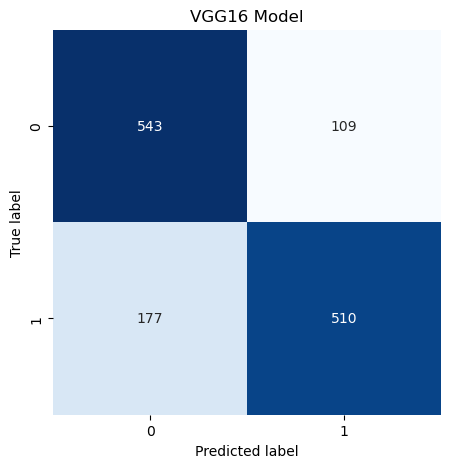

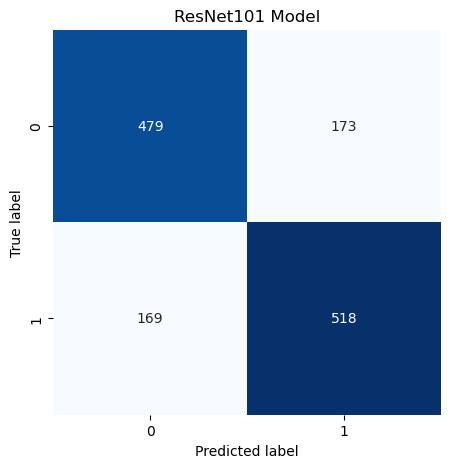

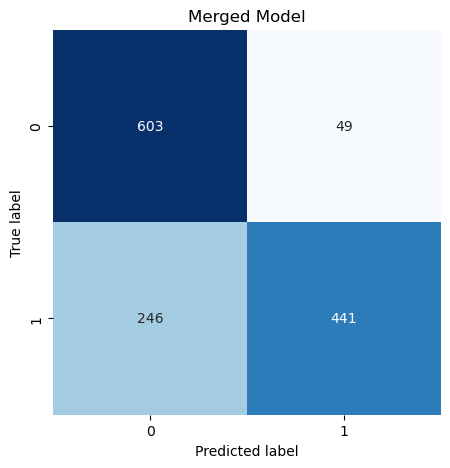

In [36]:
# For Baseline Model
baseline_predictions = baseline_model.predict(X_test)
plot_confusion_matrix(y_test, np.round(baseline_predictions), title="Baseline Model")

# For VGG16 Model
modelA_predictions = modelA.predict(X_test)
plot_confusion_matrix(y_test, np.round(modelA_predictions), title="VGG16 Model")

# For ResNet101 Model
modelB_predictions = modelB.predict(X_test)
plot_confusion_matrix(y_test, np.round(modelB_predictions), title="ResNet101 Model")

# For Merged Model
merged_predictions = merged_model.predict(X_test)
plot_confusion_matrix(y_test, np.round(merged_predictions), title="Merged Model")